In [1]:
import os
import re
from pathlib import Path
from typing import Union, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchaudio
import torchaudio.transforms as T

from torch.utils.data import DataLoader, Dataset

In [2]:
DEVICE = 'cuda:1'
INPUT_DIR = "../data/"  # path to training data
MODEL_ARTIFACTS = "../artifacts/"
VOCAB_SIZE = 20003
SEED = 42
BATCH_SIZE = 4

In [3]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 16_000

In [4]:
INPUT_SIZE = n_mels
HIDDEN_SIZE = 1024
OUTPUT_SIZE = VOCAB_SIZE
MAX_LENGTH = 40

In [13]:
from IPython.display import Audio, display


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
#     print()
#     print(waveform)
#     print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
  
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)


def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
    )
    return spectrogram(waveform)

Sample Rate: 16000
Shape: (1, 120000)
Dtype: torch.float32
 - Max:      0.500
 - Min:     -0.537
 - Mean:    -0.000
 - Std Dev:  0.129


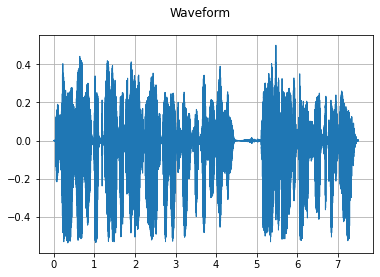

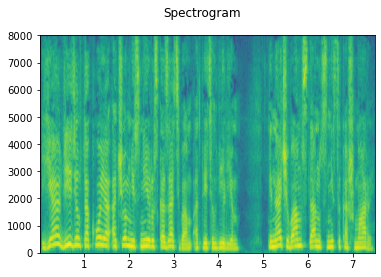

In [14]:
# make sure that the data can be loaded finely
waveform, sample_rate = torchaudio.load(INPUT_DIR + "train_wavs/1.wav")

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [17]:
# in this section, we inspect the char tokens present in the data
unique_letters = {letter for label in pd.read_csv(INPUT_DIR + "train_labels.csv").iloc[:, 1] for letter in label}
"|".join(unique_letters)

'5|к|j|y|с|т|7|р|8|о|a|й|х|g|у|е|0|в|э|b|ї|ц|ч|щ|n|h|ф|4|ш|я|ъ|2|m|w|r|6|x|o|1|п|s|м|б|н|ь| |d|v|p|k|z|а|и|ж|f|і|3|ы|t|e|з|9|г|л|c|u|i|ґ|q|_|ю|д|l'

In [8]:
# The alphabet contains only lowercase cyrrilic letters. We decided to drop latin characters along with the digits
# because there were ~200 wavs out of 10k in total containing these
# thus it can be treated as noise

a = ord('а')
alphabet = [chr(i) for i in range(a, a + 32)]
print(alphabet)

['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


In [19]:
from itertools import chain

class Mapper:
  def __init__(self, alphabet):
    self.len = len(alphabet) + 3  # extra space for special symbols  ['-', '|', 'u']
    self.i_to_ch = dict(zip(range(len(alphabet) + 3), chain(('-', '|', 'u'), alphabet)))
    self.i_to_ch[0] = '-'
    self.ch_to_i = dict(zip(unique_letters, (2 for _ in enumerate(unique_letters)))) # 2 - index of 'u'

    for val, key in enumerate(alphabet):
        self.ch_to_i[key] = val + 3
    self.ch_to_i[' '] = 1

  def to_int(self, string: str):
    tokens = list(string)
    return [self.ch_to_i[k] for k in tokens]

  def to_ch(self, ind: list):
    return [self.i_to_ch[k] for k in ind]

  def __len__(self):
    return self.len

In [26]:
# sanity check
# note: mapper will raise if called on non-lowecased inputs

vocab = Mapper(alphabet)
vocab.to_ch(vocab.to_int("urtem артем 123"))

['u', 'u', 'u', 'u', 'u', '|', 'а', 'р', 'т', 'е', 'м', '|', 'u', 'u', 'u']

In [35]:
# Dataset and Dataloader routines
# audio files are fetched from the disc storage when required
# no save RAM (on second thought, we are running this on a server with like
# 100+ GB RAM, this is kinda suboptimal)
# nevertheless, running in Colab required this

def load_item(fileid: str, ext: str, path: str) -> torch.Tensor:
    """
    Loads a file from the dataset and returns the raw waveform
    as a Torch Tensor, its sample rate as an integer, and its
    genre as a string.
    """
    file_audio = os.path.join(path, fileid + "." + ext)
    waveform, sample_rate = torchaudio.load(file_audio)
    return waveform, sample_rate

class dataSet(Dataset):
#     _ext_audio = ".wav"

    def __init__(
        self,
        data_set_path: str,
        name: str,
        transforms,
        train_val_split = None,
        labels_file_path = None,
    ) -> None:
        self.data_set_path = data_set_path
        self.file_ext = 'wav'
        self.name = name
        self.transforms = transforms
        self.labels_file_path = labels_file_path

        assert name in ('train', 'test', 'decode'), "invalid dataset type"

        if self.labels_file_path:
            self.labels = pd.read_csv(labels_file_path).to_numpy()
        else:
            self.labels = None

        fulldir = os.path.join(data_set_path)
        self._walker = []  # wav names corresponding to the label indices

        pattern = re.compile(r'[a-zA-Z0-9]+')

        if name == 'train':
            for fname in os.listdir(fulldir):
                name, ext = os.path.splitext(fname)
                label = self.labels[self.labels[:, 0] == int(name), 1][0]
                # drop all wavs with digits/latin letters
                if pattern.match(label): continue
                self._walker.append(int(name))
        else:
            for fname in os.listdir(fulldir):
                name, ext = os.path.splitext(fname)
                self._walker.append(int(name))

    def __getitem__(self, n: int):
        """
        Load the n-th sample from the dataset.

        param: n (int): The index of the sample to be loaded
        rtype: (Tensor, int, str): ``(waveform, sample_rate, label)``
        """
        fileid = self._walker[n]
        item = load_item(str(fileid), self.file_ext, self.data_set_path)
        waveform, sample_rate = item

        # transposing is required there provided that
        # the melSpectrogram would yield tensors of inappropriate format
        # for RNN input
        spec = self.transforms(waveform).squeeze().transpose(0, 1)
        # labels given <-> training mode
        if self.labels is None:
            label = torch.Tensor([0])
        else:
            label = torch.Tensor(
                vocab.to_int(
                    self.labels[self.labels[:, 0] == fileid, 1][0]
                )
            )
        return spec, label

    def __len__(self) -> int:
        return len(self._walker)

In [36]:
def padding_routine(data):
    # padding routine for dataloader
    # to be passed via collate_fn argument
    specs, labels = list(zip(*data))
    input_lengths = [x.shape[0] // 2 for x in specs]
    label_lengths = list(map(len, labels))

    specs = nn.utils.rnn.pad_sequence(specs, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return specs, labels, input_lengths, label_lengths

In [37]:
transforms = nn.Sequential(
    T.MelSpectrogram(
    sample_rate=sample_rate,
    n_mels=n_mels,
    ),
#     torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
#     torchaudio.transforms.TimeMasking(time_mask_param=35)
)

test_audio_transforms = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_mels=n_mels
)

/home/a.gotovtsev/anaconda3/envs/cringe/lib/python3.9/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [38]:
np.random.seed(SEED)
torch.manual_seed(SEED)

train_dataset = dataSet(
    INPUT_DIR+'train_wavs/',
    "train",
    transforms,
    labels_file_path=INPUT_DIR+'train_labels.csv'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=padding_routine,
)

In [39]:
len(train_dataset)

99809

In [40]:
"".join(vocab.to_ch(train_dataset[0][1].tolist()))

'тверская|стояла|подле|тани|саблиной|и|ей|казалось|что|она|ощущает|взволнованное|биение|сердца|девочки'

In [18]:
# In this section, we provide a model architecture,
# that is trained using Connectionist Temporal Classification (CTC) loss.
# The architecture is inspired by DeepSpeech2 model
# proposed by Baidu in 2015 (paper: https://arxiv.org/abs/1512.02595v1)
# The model itself consists of several CNN layers with residual connections
# followed by linear layer and set of bidirectional GRU units
# as the last step, FF layer is added yielding vocabulary-sized
# outputs with log-softmax applied

class CNNLayerNorm(nn.Module):
    """
    Layer normalization built for cnns input
    https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
    """
    def __init__(self, n_feats: int):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x: torch.Tensor):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        # (batch, channel, feature, time) 
        return self.layer_norm(x).transpose(2, 3).contiguous()


class ResidualCNN(nn.Module):
    """
    Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
    except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)

        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class ASRModel(nn.Module):
    """
    Speech Recognition Model inspired by DeepSpeech 2
    """
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(ASRModel, self).__init__()
        n_feats = n_feats//2

        # cnn for extracting hierarchical features
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*(
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ))

        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])

        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [19]:
# the model parameters used in training
n_cnn_layers, n_rnn_layers, rnn_dim = 5, 5, 1024

In [20]:
model = SpeechRecognitionModel(n_cnn_layers, n_rnn_layers, rnn_dim, len(vocab), n_mels)
model.to(DEVICE)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

In [21]:
# training hyperparameters
# at first, we utilized one cycle LR scheduling strategy
# whch anneals the LR to some maximal value
# and then decays it linearly to a very small value
# this way, the big LR value both acts like a
# regilarizer and allows faster training (with less iterations)
# however, at the end, we dropped the scheduling
# because it was really tricky to determine optimal
# hyperparameters

LR = 0.001
epochs = 5

In [22]:
criterion = nn.CTCLoss(blank=0).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), LR)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    anneal_strategy='linear'
)

In [24]:
# first, we utilized greedy decoder (which
# would yield argmaxed values at each time step)
# then we tried adding an external KenLM
# which improved the score minorly

def GreedyDecoder(
    output,
    labels,
    label_lengths,
    blank_label=0,
    collapse_repeated=True
):
    decodes = []
    # targets = []
    for i, args in enumerate(torch.argmax(output, dim=2)):
        decoded = []
        # targets.append(vocab.i_to_ch(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j-1]:
                    continue
                decoded += [index.item()]
        decodes += [vocab.to_ch(decoded)]
    return decodes
#     return decodes, targets

In [ ]:
# this section provides a sanity check
# i.e., we ensure that the model is capable of
# overfitting on a small training set

class SanityCheck(Dataset):
    def __init__(self):
        super().__init__()
        self.spec = torch.rand(418, 128)
        self.label = torch.Tensor(vocab.to_int("бебра".upper()))

    def __getitem__(self, n):
        return self.spec, self.label

    def __len__(self):
        return 10

test_model_dataloader = torch.utils.data.DataLoader(
    SanityCheck(),
    batch_size=10,
    shuffle=True,
    collate_fn=padding_routine,
)

In [47]:
for g in optimizer.param_groups:
    g['lr'] = 1e-5

In [ ]:
# Training and inference routines

SAVE_EVERY = 500
PRINT_EVERY = 50

In [55]:
for i in optimizer.param_groups:
    i['lr'] = 1e-6

In [ ]:
model.train()

for epoch in range(1):
    data_len = len(train_loader.dataset)

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)

        loss.backward()
        optimizer.step()

    if batch_idx % SAVE_EVERY == 0 or batch_idx == data_len:
        torch.save(model.state_dict(), MODEL_ARTIFACTS + f"model_ctc_{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new_save_3")
        torch.save(optimizer.state_dict(), MODEL_ARTIFACTS + f"optmi_ctc_{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new_save_3")

    if batch_idx % PRINT_EVERY == 0 or batch_idx == data_len:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(spectrograms), data_len,
            100. * batch_idx / len(train_loader), loss.item()
        ))

Train Epoch: 0 [0/100000 (0%)]	Loss: 0.841825
Train Epoch: 0 [200/100000 (0%)]	Loss: 0.836196
Train Epoch: 0 [400/100000 (0%)]	Loss: 0.841258
Train Epoch: 0 [600/100000 (1%)]	Loss: 0.734925
Train Epoch: 0 [800/100000 (1%)]	Loss: 0.745286
Train Epoch: 0 [1000/100000 (1%)]	Loss: 0.502194
Train Epoch: 0 [1200/100000 (1%)]	Loss: 0.994995
Train Epoch: 0 [1400/100000 (1%)]	Loss: 0.818395
Train Epoch: 0 [1600/100000 (2%)]	Loss: 0.811394
Train Epoch: 0 [1800/100000 (2%)]	Loss: 1.068776
Train Epoch: 0 [2000/100000 (2%)]	Loss: 0.914426
Train Epoch: 0 [2200/100000 (2%)]	Loss: 0.956696
Train Epoch: 0 [2400/100000 (2%)]	Loss: 0.981365
Train Epoch: 0 [2600/100000 (3%)]	Loss: 0.883041
Train Epoch: 0 [2800/100000 (3%)]	Loss: 0.867548
Train Epoch: 0 [3000/100000 (3%)]	Loss: 0.999999
Train Epoch: 0 [3200/100000 (3%)]	Loss: 0.782886
Train Epoch: 0 [3400/100000 (3%)]	Loss: 0.829325
Train Epoch: 0 [3600/100000 (4%)]	Loss: 1.787095
Train Epoch: 0 [3800/100000 (4%)]	Loss: 0.879871
Train Epoch: 0 [4000/100000

Train Epoch: 0 [32600/100000 (33%)]	Loss: 1.027330
Train Epoch: 0 [32800/100000 (33%)]	Loss: 1.242250
Train Epoch: 0 [33000/100000 (33%)]	Loss: 0.615982
Train Epoch: 0 [33200/100000 (33%)]	Loss: 1.250246
Train Epoch: 0 [33400/100000 (33%)]	Loss: 0.988658
Train Epoch: 0 [33600/100000 (34%)]	Loss: 1.044555
Train Epoch: 0 [33800/100000 (34%)]	Loss: 1.162020
Train Epoch: 0 [34000/100000 (34%)]	Loss: 1.201509
Train Epoch: 0 [34200/100000 (34%)]	Loss: 0.685925
Train Epoch: 0 [34400/100000 (34%)]	Loss: 0.925918
Train Epoch: 0 [34600/100000 (35%)]	Loss: 0.808306
Train Epoch: 0 [34800/100000 (35%)]	Loss: 0.683142
Train Epoch: 0 [35000/100000 (35%)]	Loss: 0.692120
Train Epoch: 0 [35200/100000 (35%)]	Loss: 0.635665
Train Epoch: 0 [35400/100000 (35%)]	Loss: 0.725376
Train Epoch: 0 [35600/100000 (36%)]	Loss: 1.160488
Train Epoch: 0 [35800/100000 (36%)]	Loss: 0.554545
Train Epoch: 0 [36000/100000 (36%)]	Loss: 0.675466
Train Epoch: 0 [36200/100000 (36%)]	Loss: 1.030655
Train Epoch: 0 [36400/100000 (3

In [ ]:
model.train()

for epoch in range(epochs):
    data_len = len(train_loader.dataset)
    
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)
        
        loss.backward()
        optimizer.step()

        if batch_idx % SAVE_EVERY == 0 or batch_idx == data_len:
            torch.save(
                model.state_dict(),
                MODEL_ARTIFACTS+f"model_ctc_{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new"
            )
            torch.save(
                optimizer.state_dict(),
                MODEL_ARTIFACTS+f"optmi_ctc_{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new"
            )

        if batch_idx % PRINT_EVERY == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()
            ))

Train Epoch: 0 [0/100000 (0%)]	Loss: 1.261534
Train Epoch: 0 [250/100000 (0%)]	Loss: 1.268709
Train Epoch: 0 [500/100000 (0%)]	Loss: 1.265332
Train Epoch: 0 [750/100000 (1%)]	Loss: 1.232084
Train Epoch: 0 [1000/100000 (1%)]	Loss: 1.019160
Train Epoch: 0 [1250/100000 (1%)]	Loss: 1.423099
Train Epoch: 0 [1500/100000 (2%)]	Loss: 1.559647
Train Epoch: 0 [1750/100000 (2%)]	Loss: 1.329281
Train Epoch: 0 [2000/100000 (2%)]	Loss: 1.300741
Train Epoch: 0 [2250/100000 (2%)]	Loss: 1.147615
Train Epoch: 0 [2500/100000 (2%)]	Loss: 1.396499
Train Epoch: 0 [2750/100000 (3%)]	Loss: 1.087614
Train Epoch: 0 [3000/100000 (3%)]	Loss: 1.439403
Train Epoch: 0 [3250/100000 (3%)]	Loss: 1.550726
Train Epoch: 0 [3500/100000 (4%)]	Loss: 1.246878
Train Epoch: 0 [3750/100000 (4%)]	Loss: 1.343563
Train Epoch: 0 [4000/100000 (4%)]	Loss: 1.046906
Train Epoch: 0 [4250/100000 (4%)]	Loss: 1.692267
Train Epoch: 0 [4500/100000 (4%)]	Loss: 1.128417
Train Epoch: 0 [4750/100000 (5%)]	Loss: 1.371917
Train Epoch: 0 [5000/10000

Train Epoch: 0 [40750/100000 (41%)]	Loss: 1.303009
Train Epoch: 0 [41000/100000 (41%)]	Loss: 1.342811
Train Epoch: 0 [41250/100000 (41%)]	Loss: 1.166379
Train Epoch: 0 [41500/100000 (42%)]	Loss: 0.970747
Train Epoch: 0 [41750/100000 (42%)]	Loss: 0.874885
Train Epoch: 0 [42000/100000 (42%)]	Loss: 1.079101
Train Epoch: 0 [42250/100000 (42%)]	Loss: 0.830304
Train Epoch: 0 [42500/100000 (42%)]	Loss: 0.936119
Train Epoch: 0 [42750/100000 (43%)]	Loss: 1.163746
Train Epoch: 0 [43000/100000 (43%)]	Loss: 0.893972
Train Epoch: 0 [43250/100000 (43%)]	Loss: 1.056875
Train Epoch: 0 [43500/100000 (44%)]	Loss: 0.980619
Train Epoch: 0 [43750/100000 (44%)]	Loss: 0.934899
Train Epoch: 0 [44000/100000 (44%)]	Loss: 1.107212
Train Epoch: 0 [44250/100000 (44%)]	Loss: 1.183320
Train Epoch: 0 [44500/100000 (44%)]	Loss: 1.343531
Train Epoch: 0 [44750/100000 (45%)]	Loss: 1.021818
Train Epoch: 0 [45000/100000 (45%)]	Loss: 1.505310
Train Epoch: 0 [45250/100000 (45%)]	Loss: 1.371978
Train Epoch: 0 [45500/100000 (4

Train Epoch: 0 [81000/100000 (81%)]	Loss: 1.168050
Train Epoch: 0 [81250/100000 (81%)]	Loss: 1.017713
Train Epoch: 0 [81500/100000 (82%)]	Loss: 1.043393
Train Epoch: 0 [81750/100000 (82%)]	Loss: 0.966110
Train Epoch: 0 [82000/100000 (82%)]	Loss: 1.261287
Train Epoch: 0 [82250/100000 (82%)]	Loss: 1.711512
Train Epoch: 0 [82500/100000 (82%)]	Loss: 1.154279
Train Epoch: 0 [82750/100000 (83%)]	Loss: 1.155218
Train Epoch: 0 [83000/100000 (83%)]	Loss: 1.288229
Train Epoch: 0 [83250/100000 (83%)]	Loss: 1.262391
Train Epoch: 0 [83500/100000 (84%)]	Loss: 0.985170
Train Epoch: 0 [83750/100000 (84%)]	Loss: 1.047102
Train Epoch: 0 [84000/100000 (84%)]	Loss: 1.531749
Train Epoch: 0 [84250/100000 (84%)]	Loss: 2.100309
Train Epoch: 0 [84500/100000 (84%)]	Loss: 1.116920
Train Epoch: 0 [84750/100000 (85%)]	Loss: 1.043962
Train Epoch: 0 [85000/100000 (85%)]	Loss: 1.208129
Train Epoch: 0 [85250/100000 (85%)]	Loss: 1.002284
Train Epoch: 0 [85500/100000 (86%)]	Loss: 1.126322
Train Epoch: 0 [85750/100000 (8

Train Epoch: 1 [21750/100000 (22%)]	Loss: 1.005710
Train Epoch: 1 [22000/100000 (22%)]	Loss: 1.176275
Train Epoch: 1 [22250/100000 (22%)]	Loss: 1.228206
Train Epoch: 1 [22500/100000 (22%)]	Loss: 1.398946
Train Epoch: 1 [22750/100000 (23%)]	Loss: 1.422660
Train Epoch: 1 [23000/100000 (23%)]	Loss: 1.073212
Train Epoch: 1 [23250/100000 (23%)]	Loss: 1.101642
Train Epoch: 1 [23500/100000 (24%)]	Loss: 1.458845
Train Epoch: 1 [23750/100000 (24%)]	Loss: 1.558319
Train Epoch: 1 [24000/100000 (24%)]	Loss: 1.177171
Train Epoch: 1 [24250/100000 (24%)]	Loss: 1.201743
Train Epoch: 1 [24500/100000 (24%)]	Loss: 1.412001
Train Epoch: 1 [24750/100000 (25%)]	Loss: 1.014024
Train Epoch: 1 [25000/100000 (25%)]	Loss: 1.475847
Train Epoch: 1 [25250/100000 (25%)]	Loss: 1.605785
Train Epoch: 1 [25500/100000 (26%)]	Loss: 0.904847
Train Epoch: 1 [25750/100000 (26%)]	Loss: 0.976921
Train Epoch: 1 [26000/100000 (26%)]	Loss: 1.241027
Train Epoch: 1 [26250/100000 (26%)]	Loss: 1.589802
Train Epoch: 1 [26500/100000 (2

Train Epoch: 1 [62000/100000 (62%)]	Loss: 1.392064
Train Epoch: 1 [62250/100000 (62%)]	Loss: 1.066116
Train Epoch: 1 [62500/100000 (62%)]	Loss: 1.176686
Train Epoch: 1 [62750/100000 (63%)]	Loss: 1.694439
Train Epoch: 1 [63000/100000 (63%)]	Loss: 1.370101
Train Epoch: 1 [63250/100000 (63%)]	Loss: 1.285626
Train Epoch: 1 [63500/100000 (64%)]	Loss: 1.404994
Train Epoch: 1 [63750/100000 (64%)]	Loss: 0.977199
Train Epoch: 1 [64000/100000 (64%)]	Loss: 1.214713
Train Epoch: 1 [64250/100000 (64%)]	Loss: 0.888111
Train Epoch: 1 [64500/100000 (64%)]	Loss: 1.162487
Train Epoch: 1 [64750/100000 (65%)]	Loss: 1.159195
Train Epoch: 1 [65000/100000 (65%)]	Loss: 0.968667
Train Epoch: 1 [65250/100000 (65%)]	Loss: 1.308816
Train Epoch: 1 [65500/100000 (66%)]	Loss: 1.262635
Train Epoch: 1 [65750/100000 (66%)]	Loss: 0.929416
Train Epoch: 1 [66000/100000 (66%)]	Loss: 1.012504
Train Epoch: 1 [66250/100000 (66%)]	Loss: 0.952132
Train Epoch: 1 [66500/100000 (66%)]	Loss: 1.190558
Train Epoch: 1 [66750/100000 (6

Train Epoch: 2 [2500/100000 (2%)]	Loss: 1.107589
Train Epoch: 2 [2750/100000 (3%)]	Loss: 1.351119
Train Epoch: 2 [3000/100000 (3%)]	Loss: 1.193215
Train Epoch: 2 [3250/100000 (3%)]	Loss: 1.165261
Train Epoch: 2 [3500/100000 (4%)]	Loss: 1.077015
Train Epoch: 2 [3750/100000 (4%)]	Loss: 1.365949
Train Epoch: 2 [4000/100000 (4%)]	Loss: 1.772842
Train Epoch: 2 [4250/100000 (4%)]	Loss: 1.072298
Train Epoch: 2 [4500/100000 (4%)]	Loss: 1.106522
Train Epoch: 2 [4750/100000 (5%)]	Loss: 1.305310
Train Epoch: 2 [5000/100000 (5%)]	Loss: 1.525905
Train Epoch: 2 [5250/100000 (5%)]	Loss: 1.340276
Train Epoch: 2 [5500/100000 (6%)]	Loss: 1.478637
Train Epoch: 2 [5750/100000 (6%)]	Loss: 1.058062
Train Epoch: 2 [6000/100000 (6%)]	Loss: 1.210630
Train Epoch: 2 [6250/100000 (6%)]	Loss: 1.152252
Train Epoch: 2 [6500/100000 (6%)]	Loss: 1.368754
Train Epoch: 2 [6750/100000 (7%)]	Loss: 1.041189
Train Epoch: 2 [7000/100000 (7%)]	Loss: 1.322057
Train Epoch: 2 [7250/100000 (7%)]	Loss: 1.289519
Train Epoch: 2 [7500

Train Epoch: 2 [43000/100000 (43%)]	Loss: 1.640023
Train Epoch: 2 [43250/100000 (43%)]	Loss: 1.467959
Train Epoch: 2 [43500/100000 (44%)]	Loss: 0.988152
Train Epoch: 2 [43750/100000 (44%)]	Loss: 1.017551
Train Epoch: 2 [44000/100000 (44%)]	Loss: 1.033165
Train Epoch: 2 [44250/100000 (44%)]	Loss: 1.124671
Train Epoch: 2 [44500/100000 (44%)]	Loss: 1.136611
Train Epoch: 2 [44750/100000 (45%)]	Loss: 0.965234
Train Epoch: 2 [45000/100000 (45%)]	Loss: 1.280397
Train Epoch: 2 [45250/100000 (45%)]	Loss: 0.975561
Train Epoch: 2 [45500/100000 (46%)]	Loss: 0.873947
Train Epoch: 2 [45750/100000 (46%)]	Loss: 0.830384
Train Epoch: 2 [46000/100000 (46%)]	Loss: 1.152430
Train Epoch: 2 [46250/100000 (46%)]	Loss: 1.347149
Train Epoch: 2 [46500/100000 (46%)]	Loss: 1.394866
Train Epoch: 2 [46750/100000 (47%)]	Loss: 0.903482
Train Epoch: 2 [47000/100000 (47%)]	Loss: 1.233427
Train Epoch: 2 [47250/100000 (47%)]	Loss: 0.887127
Train Epoch: 2 [47500/100000 (48%)]	Loss: 1.594406
Train Epoch: 2 [47750/100000 (4

Train Epoch: 2 [83250/100000 (83%)]	Loss: 0.905745
Train Epoch: 2 [83500/100000 (84%)]	Loss: 1.600822
Train Epoch: 2 [83750/100000 (84%)]	Loss: 0.839850
Train Epoch: 2 [84000/100000 (84%)]	Loss: 1.133502
Train Epoch: 2 [84250/100000 (84%)]	Loss: 1.572176
Train Epoch: 2 [84500/100000 (84%)]	Loss: 0.859991
Train Epoch: 2 [84750/100000 (85%)]	Loss: 1.094999
Train Epoch: 2 [85000/100000 (85%)]	Loss: 0.870143
Train Epoch: 2 [85250/100000 (85%)]	Loss: 0.979939
Train Epoch: 2 [85500/100000 (86%)]	Loss: 1.133290
Train Epoch: 2 [85750/100000 (86%)]	Loss: 1.245497
Train Epoch: 2 [86000/100000 (86%)]	Loss: 1.169498
Train Epoch: 2 [86250/100000 (86%)]	Loss: 1.010164
Train Epoch: 2 [86500/100000 (86%)]	Loss: 1.708022
Train Epoch: 2 [86750/100000 (87%)]	Loss: 1.069270
Train Epoch: 2 [87000/100000 (87%)]	Loss: 1.491358
Train Epoch: 2 [87250/100000 (87%)]	Loss: 1.419670
Train Epoch: 2 [87500/100000 (88%)]	Loss: 1.527007
Train Epoch: 2 [87750/100000 (88%)]	Loss: 1.173592
Train Epoch: 2 [88000/100000 (8

Train Epoch: 3 [24000/100000 (24%)]	Loss: 0.741882
Train Epoch: 3 [24250/100000 (24%)]	Loss: 1.238834
Train Epoch: 3 [24500/100000 (24%)]	Loss: 1.364095
Train Epoch: 3 [24750/100000 (25%)]	Loss: 1.427115
Train Epoch: 3 [25000/100000 (25%)]	Loss: 1.231182
Train Epoch: 3 [25250/100000 (25%)]	Loss: 1.608259
Train Epoch: 3 [25500/100000 (26%)]	Loss: 1.486754
Train Epoch: 3 [25750/100000 (26%)]	Loss: 1.083808
Train Epoch: 3 [26000/100000 (26%)]	Loss: 0.849451
Train Epoch: 3 [26250/100000 (26%)]	Loss: 1.393268
Train Epoch: 3 [26500/100000 (26%)]	Loss: 0.843024
Train Epoch: 3 [26750/100000 (27%)]	Loss: 0.922170
Train Epoch: 3 [27000/100000 (27%)]	Loss: 0.824593
Train Epoch: 3 [27250/100000 (27%)]	Loss: 1.392501
Train Epoch: 3 [27500/100000 (28%)]	Loss: 1.453025
Train Epoch: 3 [27750/100000 (28%)]	Loss: 1.119545
Train Epoch: 3 [28000/100000 (28%)]	Loss: 1.278445
Train Epoch: 3 [28250/100000 (28%)]	Loss: 0.991710
Train Epoch: 3 [28500/100000 (28%)]	Loss: 0.945824
Train Epoch: 3 [28750/100000 (2

Train Epoch: 3 [64250/100000 (64%)]	Loss: 1.200858
Train Epoch: 3 [64500/100000 (64%)]	Loss: 0.944763
Train Epoch: 3 [64750/100000 (65%)]	Loss: 1.804840
Train Epoch: 3 [65000/100000 (65%)]	Loss: 1.116192
Train Epoch: 3 [65250/100000 (65%)]	Loss: 0.829406
Train Epoch: 3 [65500/100000 (66%)]	Loss: 1.800881
Train Epoch: 3 [65750/100000 (66%)]	Loss: 0.892484
Train Epoch: 3 [66000/100000 (66%)]	Loss: 0.970966
Train Epoch: 3 [66250/100000 (66%)]	Loss: 1.155277
Train Epoch: 3 [66500/100000 (66%)]	Loss: 0.943753
Train Epoch: 3 [66750/100000 (67%)]	Loss: 0.904887
Train Epoch: 3 [67000/100000 (67%)]	Loss: 1.116118
Train Epoch: 3 [67250/100000 (67%)]	Loss: 1.065758
Train Epoch: 3 [67500/100000 (68%)]	Loss: 1.090498
Train Epoch: 3 [67750/100000 (68%)]	Loss: 0.685216
Train Epoch: 3 [68000/100000 (68%)]	Loss: 1.075243
Train Epoch: 3 [68250/100000 (68%)]	Loss: 1.233395
Train Epoch: 3 [68500/100000 (68%)]	Loss: 0.828633
Train Epoch: 3 [68750/100000 (69%)]	Loss: 0.844982
Train Epoch: 3 [69000/100000 (6

In [27]:
model.load_state_dict(torch.load(MODEL_ARTIFACTS + f"model_ctc_{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new_save"))
optimizer.load_state_dict(torch.load(MODEL_ARTIFACTS + f"optmi_ctc_{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new_save"))
# scheduler.load_state_dict(torch.load(MODEL_ARTIFACTS + f"sched_ctc{n_cnn_layers}_{n_rnn_layers}_{rnn_dim}_new"))

In [44]:
test_dataset = dataSet(
    INPUT_DIR+"test_wavs",
    "test",
    test_audio_transforms,
    None
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=padding_routine
)

" ".join(map(str, test_dataset._walker))

'113494 103657 111433 104273 111700 101956 110293 110098 106534 115329 113473 103719 106008 113059 116614 101716 118058 106367 118396 109369 107370 107117 102880 103046 107300 108176 109432 104973 107091 107293 106124 111788 114444 115413 112313 112716 110221 119515 115302 111004 111574 101248 107039 119834 107647 111902 117647 119604 102810 106429 108460 113472 105210 106914 109383 115492 101441 115231 117559 116836 119388 105780 105711 106881 106962 106370 102121 116442 107460 106163 113489 101542 104121 113700 111576 102135 106216 116925 116711 109898 114369 115009 116509 109825 119858 118952 112057 108504 106043 108167 105649 119825 112289 116216 106199 114374 119940 112807 104556 101499 118289 103913 107397 119291 105495 102266 109858 103271 113383 114823 105112 110205 110678 118511 110041 106824 116575 113052 116315 113556 113243 113992 107773 105885 117295 111753 116979 107511 117143 108966 100321 107951 110540 102822 115035 115820 106133 104006 106694 111985 111847 110468 10397

In [51]:
# evaluating on test data
# and creating the CSV with submission

sample_submission = pd.read_csv(INPUT_DIR + "sample_submission.csv")

In [50]:
from itertools import islice

for idx, i in islice(zip(test_dataset._walker, test_loader), 5):
    spectrograms, labels, input_lengths, label_lengths = i 
    spectrograms, labels = spectrograms.to(DEVICE), labels.to(DEVICE)

    output = model(spectrograms)  # (batch, time, n_class)
    output = F.log_softmax(output, dim=2)

    # here are some examples of model predictions
    print(GreedyDecoder(output, labels, label_lengths))

    # the model outputs are saved to be later decoded using ctc_decoder
    # the problem we encountered is the CUDA version of this server (10.1)
    # which did not fit the last pytorch versions
    # which supplied ctc_decoder
    # however, the nightly builds of pytorch
    # are not using GPU, thus we firstly move the prediction
    # tensors to CPU and then save those for decoding
    torch.save(output.to('cpu'), f"../outputs/{idx}.pt")

[['о', 'т', 'е', 'в', 'т', '|', 'н', 'е', '|', 'б', 'ы', 'л']]
[['с', 'в', 'о', 'и', '|', 'ж', 'а', '|', 'с', 'в', 'о', 'и', 'ж', '|', 'а', 'н', 'х', '|', 'ч', 'е', 'в', 'к', 'и', '|', 'г', 'о', 'л', 'о', 'з', 'а', 'д', 'ы', '|', 'б', 'а', 'р', 'м', 'о', 'ч', 'е', 'т', 'о', 'н']]
[['е', 'с', 'л', 'и', 'л', 'о', 'т', '|', 'к', 'о', 'н', 'у', 'ж', 'н', 'о', '|', 'т', 'а', 'к', '|', 'о', '|', 'г', 'о', 'в', 'а', 'р', 'и']]
[['л', 'о', 'н', 'д', 'о', 'м', 'ы', '|', 'п', 'о', 'р', 'ж', 'у', '|', 'ж', 'е', 'д', 'о', 'г', 'о', 'в', 'о', 'р', 'и', 'л', 'и', 'с', 'ь', '|', 'р', 'а', 'з', 'д', 'е', 'р', 'е', 'с', 'ь', 'я', 'м', '|', 'н', 'а', 'д', 'в', 'а', 'е', '|', 'п', 'р', 'е', 'и', 'к', 'е', 'ч', 'а', 'л', '|', 'п', 'р', 'а', 'и']]
[['д', 'о', 'к', 'т', 'о', 'р', 'з', 'ы', 'п', 'р', 'и', 'н', 'и', 'л', 'с', 'я', '|', 'э', 'т', 'о', 'г', 'ж', 'е', 'л', '|', 'ш', '|', 'р', 'и', 'т']]


In [52]:
model.eval()

for idx, i in zip(test_dataset._walker, test_loader):
    spectrograms, labels, input_lengths, label_lengths = i 
    spectrograms, labels = spectrograms.to(DEVICE), labels.to(DEVICE)
    output = model(spectrograms)  # (batch, time, n_class)
    output = F.log_softmax(output, dim=2)
    decoded_preds = GreedyDecoder(output, labels, label_lengths)
    sample_submission.iloc[idx - 100000, 1] = ''.join(decoded_preds[0])

In [74]:
def GreedyDecoder(emission):
    result = torch.argmax(emission, dim=2)
    return result.squeeze().tolist()

"".join(vocab.to_ch(GreedyDecoder(output)))

'---д-о--к|-т-ор----з-о-|-п-ри---ме--лл---с-я--|||-я----т-о-----ж--е-лл---в-||---р-и-----ц---'

In [53]:
sample_submission.to_csv("prediction.csv", index=False)

In [54]:
# we use kaggle's CLI to push predictions
# in order to use this, one should download
# add the kaggler token to ~/.kaggle/kaggle.json

!kaggle competitions submit -c park202204-nn-project -f prediction.csv -m "fixed index mapping"

100%|███████████████████████████████████████| 2.42M/2.42M [00:02<00:00, 960kB/s]
Successfully submitted to Проект по курсу нейронных сетей